In [32]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

ROOT = Path(os.getcwd()).parents[0]
ROOT

PosixPath('/Users/dantrainer/projects/cancer_research')

In [2]:
DATA_PATH = os.path.join(ROOT, 'data', 'TCGA-BRCA.star_fpkm-uq.tsv')
CLINICAL_DATA_PATH = os.path.join(ROOT, 'data', 'TCGA-BRCA.clinical.tsv')

In [3]:
df = pd.read_csv(DATA_PATH, sep='\t', index_col=0).drop_duplicates()
df_clinical = pd.read_csv(CLINICAL_DATA_PATH, sep='\t', index_col=0).drop_duplicates()

display(df.head())
print(f"Number of genes: {df.shape[0]}")
print(f"Number of samples: {df.shape[1]}")
display(df_clinical.head())
print(f"Number of clinical samples: {df_clinical.shape[0]}")
print(f"Number of clinical features: {df_clinical.shape[1]}")

,TCGA-D8-A146-01A,TCGA-AQ-A0Y5-01A,TCGA-C8-A274-01A,TCGA-BH-A0BD-01A,TCGA-B6-A1KC-01B,TCGA-AC-A62V-01A,TCGA-AO-A0J5-01A,TCGA-BH-A0B1-01A,TCGA-A2-A0YM-01A,TCGA-AO-A03N-01B,...,TCGA-E2-A1IG-01A,TCGA-E9-A1NA-01A,TCGA-D8-A1JP-01A,TCGA-AR-A252-01A,TCGA-D8-A1XL-01A,TCGA-BH-A0EI-01A,TCGA-E2-A1IO-01A,TCGA-E2-A15R-01A,TCGA-B6-A0IP-01A,TCGA-A1-A0SN-01A
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,3.767708,2.132741,4.768010,3.049735,3.009311,2.262163,2.929999,4.243105,4.231540,3.126461,...,3.083077,2.463256,3.263365,3.203264,3.653874,4.470745,4.214863,1.175109,5.008083,1.993783
ENSG00000000005.6,1.759454,0.146003,0.000000,1.071763,0.185993,0.308594,0.467071,0.121281,0.124196,0.000000,...,0.038015,0.045024,0.023184,1.922426,0.000000,0.104739,0.224658,0.127501,0.165172,0.015783
ENSG00000000419.13,4.920541,5.284151,5.051694,4.618797,4.852973,5.364065,3.958935,5.171995,4.771500,5.550193,...,4.556411,4.596321,5.213518,4.374831,5.696970,5.234413,4.876325,4.975405,4.569892,6.213147
ENSG00000000457.14,2.612588,2.428544,3.356299,2.680774,2.381671,1.128095,2.787265,2.398214,1.637378,1.876527,...,2.257493,2.141498,3.250295,2.203232,2.196827,2.030407,2.303109,2.895225,2.681697,2.431356
ENSG00000000460.17,1.363395,1.158337,2.458172,2.494236,1.565841,1.249809,1.221939,1.857344,2.197771,1.396050,...,1.223670,1.222805,2.184534,1.291250,1.736778,1.531219,1.123070,1.955015,1.791314,1.716025


Number of genes: 58049
Number of samples: 1226


,id,disease_type,case_id,submitter_id,primary_site,alcohol_history.exposures,race.demographic,gender.demographic,ethnicity.demographic,vital_status.demographic,...,days_to_collection.samples,initial_weight.samples,preservation_method.samples,pathology_report_uuid.samples,oct_embedded.samples,specimen_type.samples,days_to_sample_procurement.samples,is_ffpe.samples,tissue_type.samples,annotations.samples
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-BH-A0W3-01A,3c612e12-6de8-44fa-a095-805c45474821,Ductal and Lobular Neoplasms,3c612e12-6de8-44fa-a095-805c45474821,TCGA-BH-A0W3,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,85.0,120.0,OCT,801A4E2F-E26E-424F-BF42-CD0D9CD62BCE,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-AR-A24V-01A,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,Ductal and Lobular Neoplasms,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,TCGA-AR-A24V,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,1720.0,400.0,OCT,468CD293-C9F7-43C6-A40A-18FCDD22F6AA,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-E9-A1NE-01A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,31.0,280.0,OCT,CF6E29A2-FAE6-45BB-B625-33877887A89E,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-E9-A1NE-11A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,31.0,830.0,OCT,NaN,True,Solid Tissue,NaN,False,Normal,NaN
TCGA-AC-A8OQ-01A,dfaabd03-2d40-4422-b210-caf112ff4229,Ductal and Lobular Neoplasms,dfaabd03-2d40-4422-b210-caf112ff4229,TCGA-AC-A8OQ,Breast,Not Reported,black or african american,female,not hispanic or latino,Alive,...,742.0,100.0,Unknown,FFA6F9F3-71C1-4AF9-B9F7-0466550EBC90,False,Solid Tissue,NaN,False,Tumor,NaN


Number of clinical samples: 1255
Number of clinical features: 84


## Estimate the Survival Function using Kaplan-Meier

Here, the `days_to_death.demographic` columns represent the days from initial diagnosis to death. This represents the time value for patients who had the event. The `days_to_last_follow_up.diagnosis` column represents the number of days from initial diagnosis to the last known follow up appointment, representing the time value for patients who are censored.

In [4]:
df_clinical[["days_to_death.demographic", "days_to_last_follow_up.diagnoses"]]

,days_to_death.demographic,days_to_last_follow_up.diagnoses
sample,,
TCGA-BH-A0W3-01A,NaN,728.0
TCGA-AR-A24V-01A,NaN,3203.0
TCGA-E9-A1NE-01A,NaN,1088.0
TCGA-E9-A1NE-11A,NaN,1088.0
TCGA-AC-A8OQ-01A,NaN,34.0
...,...,...
TCGA-BH-A1FH-11B,1034.0,NaN
TCGA-BH-A1FH-01A,1034.0,NaN
TCGA-AR-A1AO-01A,NaN,2618.0


Create an event and duration column following the standard Kaplan-Meier conventions.

In [5]:
df_clinical["event"] = df_clinical["days_to_last_follow_up.diagnoses"].isna().astype(int)
df_clinical["duration"] = df_clinical.apply(
    lambda x: x["days_to_death.demographic"] if x["event"] else x["days_to_last_follow_up.diagnoses"], 
    axis=1
    )
df_clinical["duration"] = df_clinical["duration"]/365  # Convert to years
df_clinical[["event", "duration"]]

,event,duration
sample,,
TCGA-BH-A0W3-01A,0,1.994521
TCGA-AR-A24V-01A,0,8.775342
TCGA-E9-A1NE-01A,0,2.980822
TCGA-E9-A1NE-11A,0,2.980822
TCGA-AC-A8OQ-01A,0,0.093151
...,...,...
TCGA-BH-A1FH-11B,1,2.832877
TCGA-BH-A1FH-01A,1,2.832877
TCGA-AR-A1AO-01A,0,7.172603


Text(0.5, 1.0, 'Distribution of survival duration in TCGA-BRCA dataset')

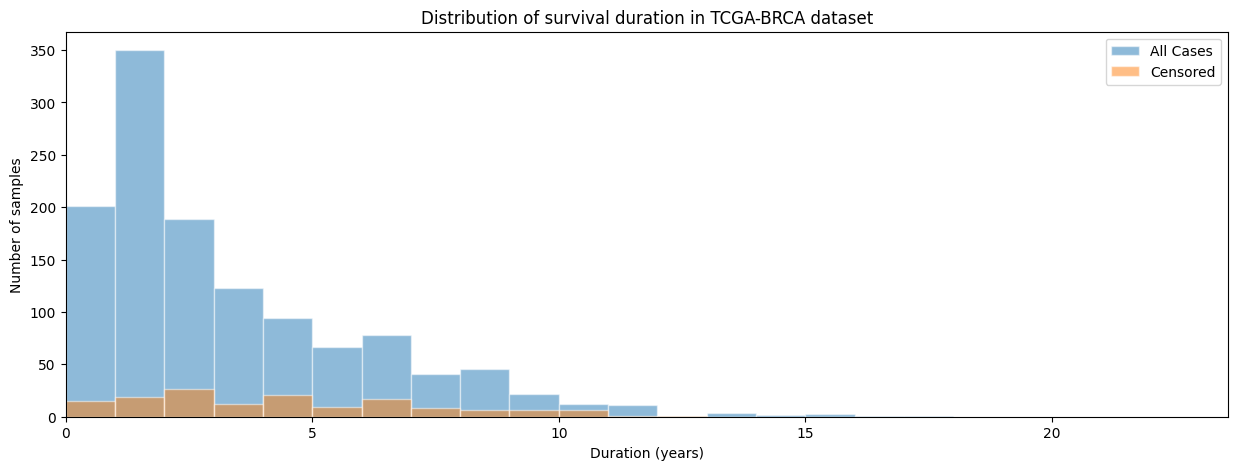

In [6]:
_, axes = plt.subplots(figsize=(15,5))

plt.hist(
    df_clinical["duration"], 
    bins=np.arange(0, 20, 1),
    alpha=0.5,
    label='All Cases',
    edgecolor='w'
)
plt.hist(
    df_clinical[df_clinical["event"]==1]["duration"], 
    bins=np.arange(0, 20, 1),
    alpha=0.5,
    label='Censored',
    edgecolor='w'
)
plt.xlim(0, df_clinical["duration"].max())
plt.xlabel("Duration (years)")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Distribution of survival duration in TCGA-BRCA dataset")

(0.0, 1.0)

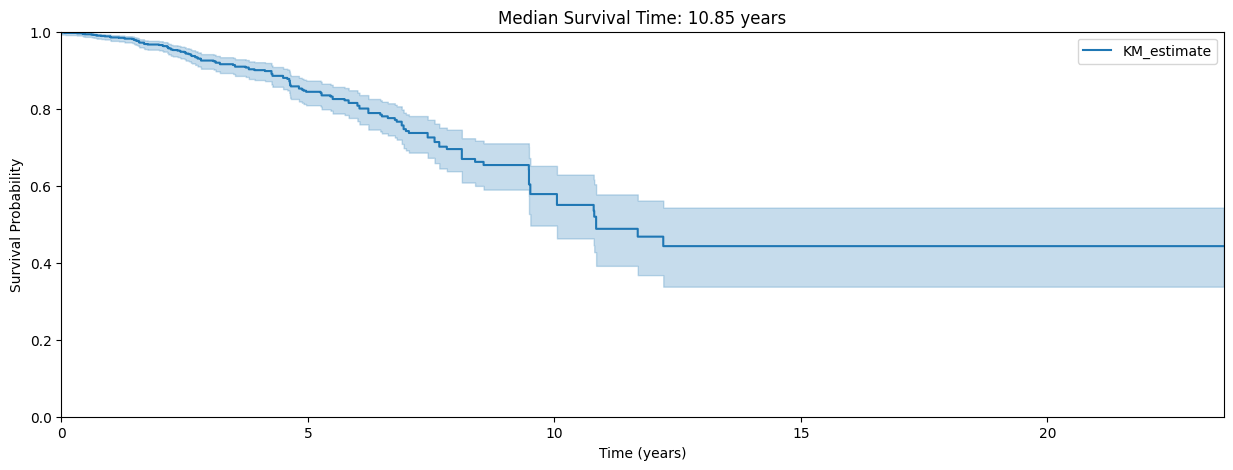

In [7]:
kmf = KaplanMeierFitter()

df_clinical = df_clinical.dropna(subset=["event", "duration"])
kmf.fit(df_clinical["duration"], event_observed=df_clinical["event"])

_, axes = plt.subplots(figsize=(15,5))
kmf.plot_survival_function()
plt.title(f"Median Survival Time: {kmf.median_survival_time_:.2f} years")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.xlim(0, df_clinical["duration"].max())
plt.ylim(0, 1)

In this specific dataset, after 12 years of follow-up, no further deaths were observed. About 45% of the patients in this cohort survived for at least 12 years, at which point we no longer have complete information on them because the study period ended.

## Analyze Survival Time vs. ESR1 Expression

In [9]:
df

,TCGA-D8-A146-01A,TCGA-AQ-A0Y5-01A,TCGA-C8-A274-01A,TCGA-BH-A0BD-01A,TCGA-B6-A1KC-01B,TCGA-AC-A62V-01A,TCGA-AO-A0J5-01A,TCGA-BH-A0B1-01A,TCGA-A2-A0YM-01A,TCGA-AO-A03N-01B,...,TCGA-E2-A1IG-01A,TCGA-E9-A1NA-01A,TCGA-D8-A1JP-01A,TCGA-AR-A252-01A,TCGA-D8-A1XL-01A,TCGA-BH-A0EI-01A,TCGA-E2-A1IO-01A,TCGA-E2-A15R-01A,TCGA-B6-A0IP-01A,TCGA-A1-A0SN-01A
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,3.767708,2.132741,4.768010,3.049735,3.009311,2.262163,2.929999,4.243105,4.231540,3.126461,...,3.083077,2.463256,3.263365,3.203264,3.653874,4.470745,4.214863,1.175109,5.008083,1.993783
ENSG00000000005.6,1.759454,0.146003,0.000000,1.071763,0.185993,0.308594,0.467071,0.121281,0.124196,0.000000,...,0.038015,0.045024,0.023184,1.922426,0.000000,0.104739,0.224658,0.127501,0.165172,0.015783
ENSG00000000419.13,4.920541,5.284151,5.051694,4.618797,4.852973,5.364065,3.958935,5.171995,4.771500,5.550193,...,4.556411,4.596321,5.213518,4.374831,5.696970,5.234413,4.876325,4.975405,4.569892,6.213147
ENSG00000000457.14,2.612588,2.428544,3.356299,2.680774,2.381671,1.128095,2.787265,2.398214,1.637378,1.876527,...,2.257493,2.141498,3.250295,2.203232,2.196827,2.030407,2.303109,2.895225,2.681697,2.431356
ENSG00000000460.17,1.363395,1.158337,2.458172,2.494236,1.565841,1.249809,1.221939,1.857344,2.197771,1.396050,...,1.223670,1.222805,2.184534,1.291250,1.736778,1.531219,1.123070,1.955015,1.791314,1.716025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288667.1,0.000000,0.000000,0.000000,0.335026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000288669.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005328,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005903
ENSG00000288670.1,1.884051,3.073066,3.046683,2.962568,3.873292,1.925961,1.918463,2.724148,2.375123,1.557091,...,3.040822,1.513137,2.811985,1.768460,2.244826,2.248899,1.845952,3.325012,2.791106,1.895109


In [10]:
ESR1_Ensembl_ID = 'ENSG00000091831'

df.index = [id_.split('.')[0] for id_ in df.index]
esr_expression = df.loc[ESR1_Ensembl_ID]

Text(0, 0.5, 'Frequency')

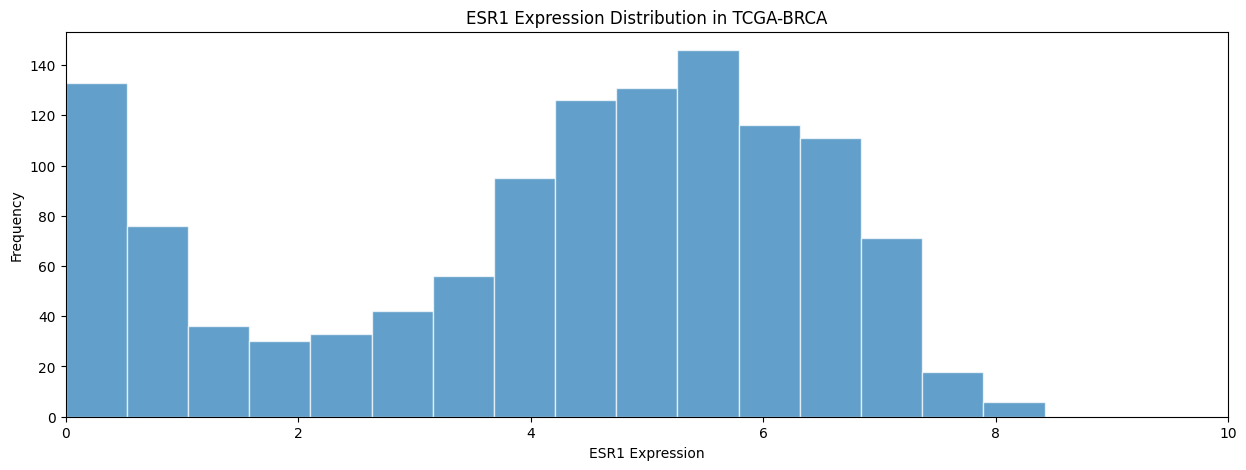

In [11]:
_, axes = plt.subplots(figsize=(15, 5))

axes.hist(
    esr_expression,
    bins=np.linspace(0, 10, 20),
    edgecolor='white',
    alpha=0.7,
    )

axes.set_xlim(0, 10)

plt.title('ESR1 Expression Distribution in TCGA-BRCA')
plt.xlabel('ESR1 Expression')
plt.ylabel('Frequency')

Merge ESR1 with Clinical Data

In [12]:
df_clinical = df_clinical.merge(esr_expression, left_index=True, right_index=True) 

In [23]:
above_median_expression = df_clinical[ESR1_Ensembl_ID] > esr_expression.median()

In [33]:
results = logrank_test(
    durations_A = df_clinical[~above_median_expression]['duration'],
    event_observed_A = df_clinical[~above_median_expression]['event'],
    label_A = 'Low ESR1 Expression',

    durations_B = df_clinical[above_median_expression]['duration'],
    event_observed_B = df_clinical[above_median_expression]['event'],
    label_B = 'High ESR1 Expression'
)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
           label_A = Low ESR1 Expression
           label_B = High ESR1 Expression
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.81 0.18      2.48

(0.0, 1.0)

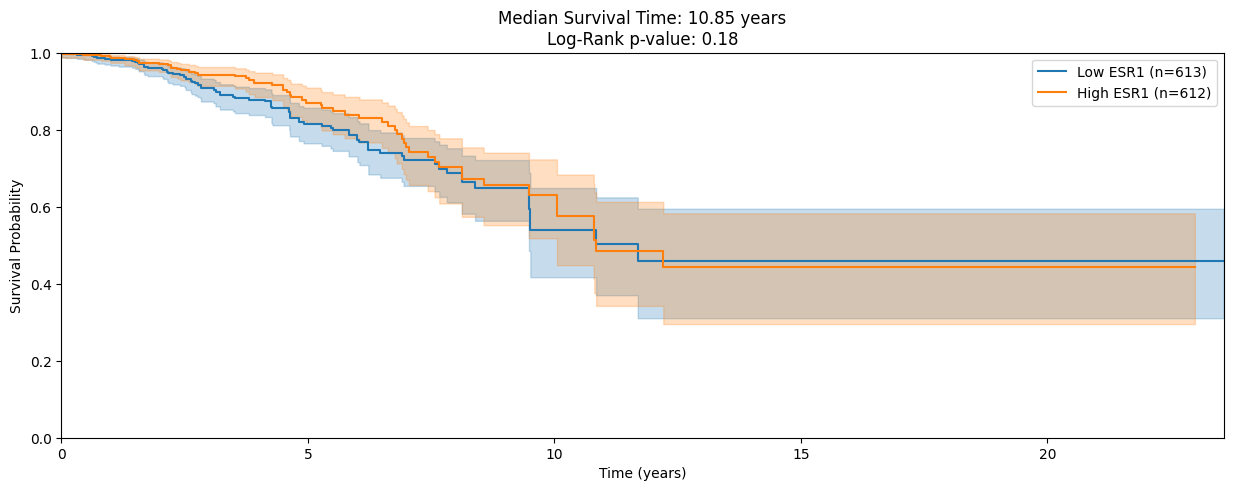

In [37]:
kmf = KaplanMeierFitter()

df_clinical = df_clinical.dropna(subset=["event", "duration"])
kmf.fit(
    df_clinical[~above_median_expression]["duration"], 
    event_observed=df_clinical[~above_median_expression]["event"],
    label='Low ESR1 (n=%d)' % df_clinical[~above_median_expression].shape[0]
    )

_, axes = plt.subplots(figsize=(15,5))
kmf.plot_survival_function(ax = axes)

kmf.fit(
    df_clinical[above_median_expression]["duration"], 
    event_observed=df_clinical[above_median_expression]["event"],
    label='High ESR1 (n=%d)' % df_clinical[above_median_expression].shape[0]
    )

kmf.plot_survival_function(ax = axes)
plt.title(f"Median Survival Time: {kmf.median_survival_time_:.2f} years\nLog-Rank p-value: {results.p_value:.2f}")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.xlim(0, df_clinical["duration"].max())
plt.ylim(0, 1)

The p-value indicates that there is no statistical significance between the "High" vs. "Low" ESR1 groups